In [1]:
from plotTDP import *
from cnn_predictor import CNN_Predictor
from early_tdp import *

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
W_list = [
    "2TGLXRTZ",
    "3ZH607HZ",
    "3ZH61Z0Z",
    "3ZH609ZZ",
    "2TGLYS7Z",
    "3ZH61PWZ",
    "3ZH5Z5XZ",
    "3ZH620SZ",
    "3ZH6200Z",
    "3ZH5X4UZ",
    "3ZH5LL0Z",
    "2TGLXTRZ"
]

R_list = [
    "2GJ5BMAD",
    "2TGLU8RZ"
]

V_list = [
    "2GG02VGL",
    "2GH2KP7S",
    "2GHR65SS",
    "2GJ2XK9S",
    "2GJ3R6SD",
    "2GJ68Y3S",
    "2TGLJDWZ",
    "2GJ69HJS",
    "3ZH4NYAZ",
    "ZGG0AABA",
]

In [3]:
model_path = r"C:\Users\1000303969\OneDrive - Western Digital\work\tdp classification\models\best_resnet18d_all_noNorm_kv1_fold4.pt"
predictor = CNN_Predictor(model_path=model_path)
model = predictor.load_model()

['6FPW' '0000']


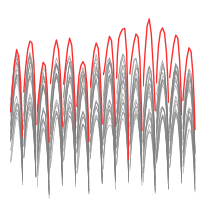

2TGLXRTZ 8
{'head': [8], 'TDP_level': ['high'], 'TDP_change': ['yes'], 'TDP_early': ['yes']}
{'class': ['high_decrease', 'normal_increase', 'high_tdp'], 'confidence': [46.87, 43.48, 5.21]}


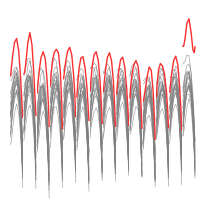

3ZH607HZ 3
{'head': [3], 'TDP_level': ['normal'], 'TDP_change': ['yes'], 'TDP_early': ['yes']}
{'class': ['normal_increase', 'high_decrease', 'high_tdp'], 'confidence': [54.21, 26.53, 15.17]}


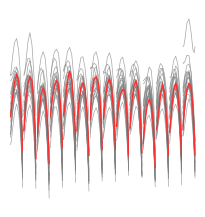

3ZH607HZ 5
{'head': [5], 'TDP_level': ['normal'], 'TDP_change': ['no'], 'TDP_early': ['yes']}
{'class': ['other_all', 'airmix_helium_leak_full', 'normal_increase'], 'confidence': [85.53, 5.62, 4.46]}


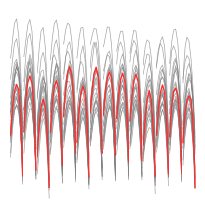

3ZH61Z0Z 17
{'head': [17], 'TDP_level': ['normal'], 'TDP_change': ['no'], 'TDP_early': ['yes']}
{'class': ['other_all', 'normal_OD-ID', 'normal_increase'], 'confidence': [99.65, 0.11, 0.09]}


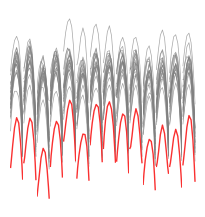

3ZH609ZZ 9
{'head': [9], 'TDP_level': ['low'], 'TDP_change': ['yes'], 'TDP_early': ['yes']}
{'class': ['low_tdp', 'low_increase', 'normal_decrease'], 'confidence': [96.81, 3.07, 0.04]}


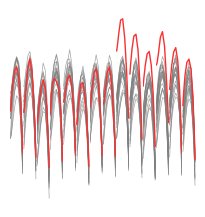

2TGLYS7Z 19
{'head': [19], 'TDP_level': ['normal'], 'TDP_change': ['yes'], 'TDP_early': ['yes']}
{'class': ['high_decrease', 'normal_increase', 'high_recovery'], 'confidence': [75.96, 16.26, 5.29]}


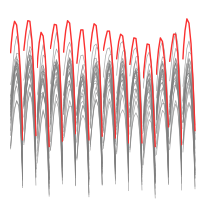

3ZH61PWZ 9
{'head': [9], 'TDP_level': ['high'], 'TDP_change': ['no'], 'TDP_early': ['yes']}
{'class': ['high_tdp', 'high_decrease', 'normal_increase'], 'confidence': [47.35, 38.77, 9.7]}


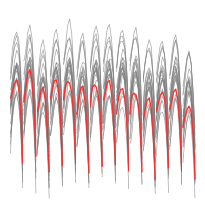

3ZH5Z5XZ 5
{'head': [5], 'TDP_level': ['normal'], 'TDP_change': ['no'], 'TDP_early': ['yes']}
{'class': ['other_all', 'normal_ID-OD', 'normal_decrease'], 'confidence': [99.53, 0.14, 0.14]}


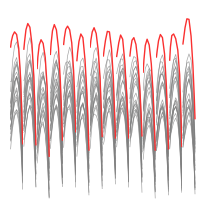

3ZH620SZ 1
{'head': [1], 'TDP_level': ['high'], 'TDP_change': ['yes'], 'TDP_early': ['yes']}
{'class': ['high_tdp', 'normal_increase', 'high_decrease'], 'confidence': [92.69, 5.94, 0.63]}


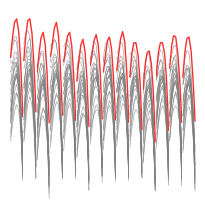

3ZH6200Z 9
{'head': [9], 'TDP_level': ['high'], 'TDP_change': ['no'], 'TDP_early': ['yes']}
{'class': ['high_decrease', 'high_tdp', 'normal_increase'], 'confidence': [42.02, 28.42, 24.7]}


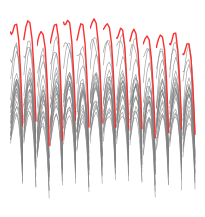

3ZH5X4UZ 13
{'head': [13], 'TDP_level': ['high'], 'TDP_change': ['no'], 'TDP_early': ['yes']}
{'class': ['high_tdp', 'normal_increase', 'high_od+id'], 'confidence': [45.25, 36.48, 4.19]}


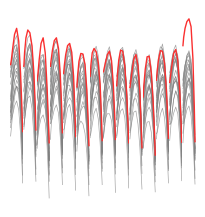

3ZH5LL0Z 17
{'head': [17], 'TDP_level': ['normal'], 'TDP_change': ['no'], 'TDP_early': ['yes']}
{'class': ['other_all', 'normal_increase', 'high_recovery'], 'confidence': [41.32, 34.53, 5.76]}


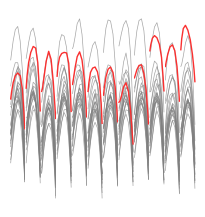

2TGLXTRZ 2
{'head': [2], 'TDP_level': ['high'], 'TDP_change': ['yes'], 'TDP_early': ['no']}
{'class': ['normal_increase', 'high_decrease', 'normal_decrease'], 'confidence': [71.34, 10.42, 9.81]}


In [4]:
from PIL import Image

csv_path = r"C:\Users\1000303969\OneDrive - Western Digital\work\tdp classification\VL_TDP\6FPW\TDP_6FPW.csv"
# csv_path = r"C:\Users\1000303969\OneDrive - Western Digital\work\tdp classification\VL_TDP\6FPR\TDP_6FPR.csv"
# csv_path = r"C:\Users\1000303969\OneDrive - Western Digital\work\tdp classification\VL_TDP\6FPV\TDP_6FPV_R_W.csv"

df = pd.read_csv(csv_path)
# hddsn_list = df["hddsn"].unique()
# ## sort hddsn_list
# hddsn_list = sorted(hddsn_list)
ec = df["pfcode"].unique()
print(ec)
if ("6FPR" in ec) and ("6FPV" not in ec):
    hddsn_list = R_list
elif "6FPW" in ec:
    hddsn_list = W_list
else:
    hddsn_list = V_list

for hddsn in hddsn_list:
    df_filter = df[df["hddsn"] == hddsn]
    failure_head_list = get_bad_head(df=df_filter)
    n_fh = len(failure_head_list)
    for fh_i in range(n_fh):
        tdp = TDP(df=df_filter, bad_head_list=[failure_head_list[fh_i]])
        fig = tdp.display()
        plt.show()
        result = predictor.predict(model, fig)
        fig2 = predictor.convert_to_arr(fig)
        result = predictor.predict(model, fig, is_path=False)
        obj = EARLY_TDP(df=df_filter, bad_head_list=[failure_head_list[fh_i]])
        symptom = obj.run()
        print(hddsn, failure_head_list[fh_i])
        print(symptom)  
        print(result)
        print("==================================================")


# hddsn_filter = "3ZH5Z5XZ"
# df_filter = df[df["hddsn"] == hddsn_filter]
# failure_head_list = get_bad_head(df=df_filter)
# print(failure_head_list)
# tdp = TDP(df=df_filter, bad_head_list=failure_head_list)
# fig = tdp.display()
# plt.show()

# obj = EARLY_TDP(df=df_filter, bad_head_list=failure_head_list)
# symptom = obj.run()
# print(symptom)

# result = predictor.predict(model, fig)
# fig2 = predictor.convert_to_arr(fig)

# result = predictor.predict(model, fig, is_path=False)
# print(result)

In [49]:
test_dict = {
        'high_tdp': 51.25, 
        'assembly': 96.16, 
        'other_increase_decrease': 99.85, 
        'other_recovery': 99.99, 
        'other_hl_inc_dec': 80.33, 
        'head': [13],
        "early_tdp_flag": ['yes'],
}

In [52]:
other_counter = 0
all_keys = list(test_dict.keys())
n_all_keys = len(all_keys)

other_flag = False
other_dict = {}
non_other_dict = {}

for key, value in test_dict.items():
    if "head" in key or "early_tdp_flag" in key:
        continue

    if "other" in key:
        other_counter += 1
        other_dict[key] = value
    else:
        non_other_dict[key] = value

    if other_counter == n_all_keys - 1:
        other_flag = True
        # print(other_dict)
        break
    
if other_flag:
    new_dict = {}
    new_dict["ealry_tdp_flag"] = test_dict["early_tdp_flag"]

    avg_other_confi  = np.mean(list(other_dict.values()))
    new_dict["other"] = avg_other_confi
    new_dict["head"] = test_dict["head"]
    print(new_dict)
else:
    sorted_confidence = sorted(non_other_dict.values(), reverse=True)

    new_dict = {}
    temp_list = []

    for confi in sorted_confidence:
        for key, value in non_other_dict.items():
            if confi == value:
                temp_list.append(key)

    new_dict["head"] = test_dict["head"]
    new_dict["class"] = temp_list
    new_dict["confidence"] = [sorted_confidence[0]]
    new_dict["ealry_tdp_flag"] = test_dict["early_tdp_flag"]
    print(new_dict)

{'head': [13], 'class': ['assembly', 'high_tdp'], 'confidence': [96.16], 'ealry_tdp_flag': ['yes']}
